**Klasifikasi gambar Rock-Paper-Scissors**

Dataset: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

# **Install Package dan Import Library**

In [1]:
pip install split_folders

In [2]:
! pip install -q kaggle

In [3]:
import tensorflow as tf
import zipfile, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import scipy as sp
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
%matplotlib inline

# Cek versi tensorflow
print(tf.__version__)

2.15.0


In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanbyu","key":"6315917ff5833a191af787ea7c399e2b"}'}

# **Mengunduh Dataset Rock-Paper-Scissors**

In [5]:
# Membuat direktori dataset pada default direktori '/content'
!mkdir RockPaperScissors
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d drgfreeman/rockpaperscissors -p /content/RockPaperScissors/

100% 305M/306M [00:03<00:00, 49.8MB/s]
100% 306M/306M [00:03<00:00, 88.1MB/s]


# **Melakukan Split Data**

In [6]:
# Mengekstraksi file zip
dataset_zip = '/content/RockPaperScissors/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall('/content/RockPaperScissors/')
zip_ref.close()

In [7]:
# Memisahkan data menjadi data train dan data validation
dir_base = '/content/RockPaperScissors/rps-cv-images/'
dir_fixed = '/content/RockPaperScissors/'
splitfolders.ratio(dir_base, output=dir_fixed, seed=1337, ratio=(.8, .2))

dir_train = os.path.join(dir_fixed, 'train')
dir_val = os.path.join(dir_fixed, 'val')

Copying files: 2188 files [00:00, 4591.03 files/s]


In [8]:
# Membuat path direktori untuk data train
dir_train_rock = os.path.join(dir_train, 'rock')
dir_train_paper = os.path.join(dir_train, 'paper')
dir_train_scissors = os.path.join(dir_train, 'scissors')

# Membuat path direktori untuk data validation
dir_val_rock = os.path.join(dir_val, 'rock')
dir_val_paper = os.path.join(dir_val, 'paper')
dir_val_scissors = os.path.join(dir_val, 'scissors')

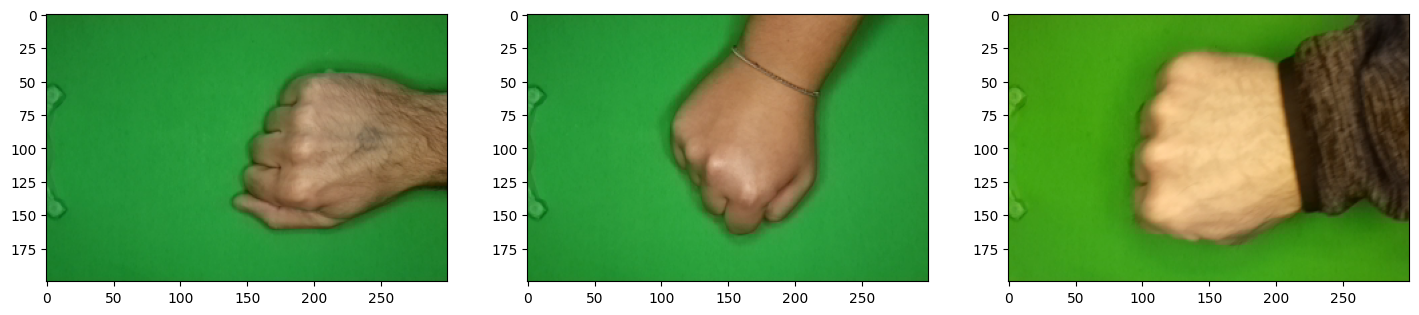

In [9]:
# Mengambil daftar file dalam direktori rock, paper, scissors
dir_rock = os.listdir(dir_train_rock)
dir_paper = os.listdir(dir_train_paper)
dir_scissors = os.listdir(dir_train_scissors)

# Menampilkan data pada direktori rock
plt.figure(figsize=(30, 30))
for i, path_rock in enumerate(dir_rock[:3]):
  sp = plt.subplot(1, 5, i+1)
  image = mpimg.imread(os.path.join(dir_train_rock, path_rock))
  plt.imshow(image)
plt.show()

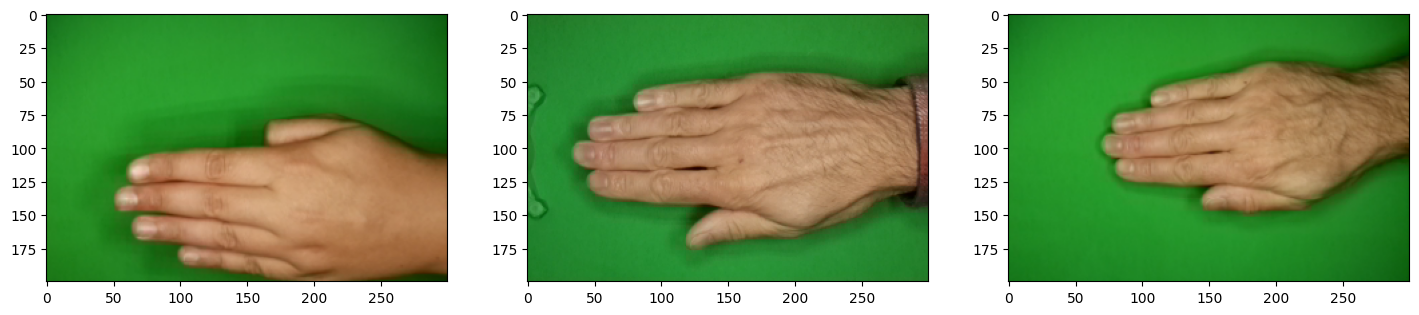

In [10]:
# Menampilkan data pada direktori paper
plt.figure(figsize=(30, 30))
for i, path_paper in enumerate(dir_paper[:3]):
  sp = plt.subplot(1, 5, i+1)
  image = mpimg.imread(os.path.join(dir_train_paper, path_paper))
  plt.imshow(image)
plt.show()

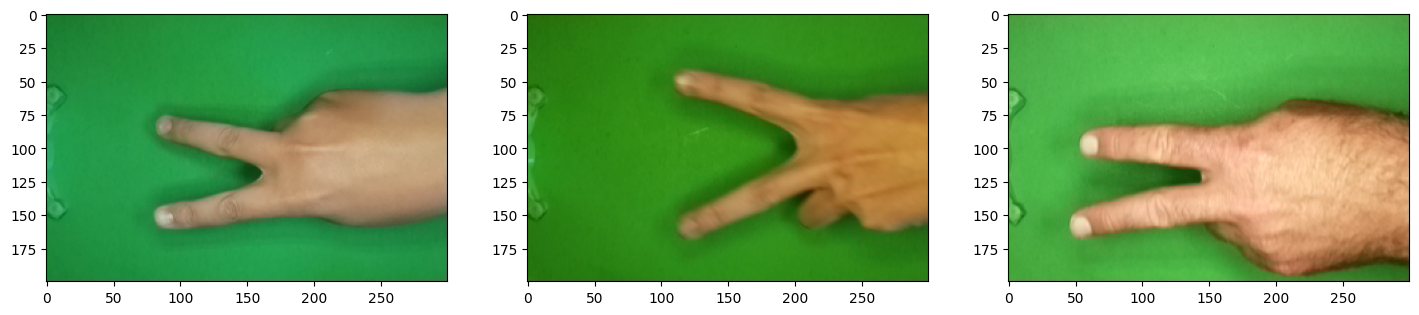

In [11]:
# Menampilkan data pada direktori scissors
plt.figure(figsize=(30, 30))
for i, path_scissors in enumerate(dir_scissors[:3]):
  sp = plt.subplot(1, 5, i+1)
  image = mpimg.imread(os.path.join(dir_train_scissors, path_scissors))
  plt.imshow(image)
plt.show()

In [12]:
# Mengarahkan direktori untuk menampilkan data pada direktori rock, paper, dan scissors
image_rock = len(os.listdir('/content/RockPaperScissors/rock/'))
image_paper = len(os.listdir('/content/RockPaperScissors/paper/'))
image_scissors = len(os.listdir('/content/RockPaperScissors/scissors/'))

# Mencetak total jumah data pada masing-masing direktori rock, paper, dan scissors
print("Rock Image     :", image_rock)
print("Paper Image    :", image_paper)
print("Scissors Image :", image_scissors)

Rock Image     : 726
Paper Image    : 712
Scissors Image : 750


# **Implementasi ImageDataGenerator untuk Augementasi Data Gambar**

In [13]:
# Inisialisasi objek ImageDataGenerator untuk augmentasi data pelatihan
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.2,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range=0.2,
                    validation_split=0.4,
                    fill_mode='nearest')

# Inisialisasi objek ImageDataGenerator untuk augmentasi data validation
validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.2,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range=0.2,
                    validation_split=0.4,
                    fill_mode='nearest')

In [14]:
# Menggunakan mode categorical pada train dan validation generator
train_generator = train_datagen.flow_from_directory(
        dir_base,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        dir_base,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=True)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


# **Membangun Model Convolutional Neural Network (CNN)**

In [15]:
# Membuat arsitektur model sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),

    # Dropout
    Dropout(0.2),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

# **Melakukan Training Model**

In [16]:
# Compile model dengan RMSprop optimizer loss function 'categorical_crossentropy'
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Penggunaan EarlyStopping callback
callback = EarlyStopping(
    patience=7,
    verbose=2,
    mode='auto')

# Pelatihan model dengan model.fit
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=5,
    verbose=2,
    callbacks=[callback])

Epoch 1/20
41/41 - 18s - loss: 1.1399 - accuracy: 0.3752 - val_loss: 1.0549 - val_accuracy: 0.3562 - 18s/epoch - 450ms/step
Epoch 2/20
41/41 - 12s - loss: 0.8214 - accuracy: 0.6591 - val_loss: 0.6004 - val_accuracy: 0.7437 - 12s/epoch - 301ms/step
Epoch 3/20
41/41 - 11s - loss: 0.4486 - accuracy: 0.8378 - val_loss: 0.3019 - val_accuracy: 0.9062 - 11s/epoch - 279ms/step
Epoch 4/20
41/41 - 11s - loss: 0.3464 - accuracy: 0.8791 - val_loss: 0.2254 - val_accuracy: 0.9625 - 11s/epoch - 279ms/step
Epoch 5/20
41/41 - 12s - loss: 0.2890 - accuracy: 0.9017 - val_loss: 0.2520 - val_accuracy: 0.9187 - 12s/epoch - 292ms/step
Epoch 6/20
41/41 - 12s - loss: 0.2364 - accuracy: 0.9142 - val_loss: 0.2385 - val_accuracy: 0.9312 - 12s/epoch - 281ms/step
Epoch 7/20
41/41 - 13s - loss: 0.2133 - accuracy: 0.9275 - val_loss: 0.1146 - val_accuracy: 0.9625 - 13s/epoch - 321ms/step
Epoch 8/20
41/41 - 11s - loss: 0.1696 - accuracy: 0.9407 - val_loss: 0.1731 - val_accuracy: 0.9688 - 11s/epoch - 280ms/step
Epoch 9/

# **Evaluasi Training Model untuk Melihat Hasil dari Loss dan Accuracy**

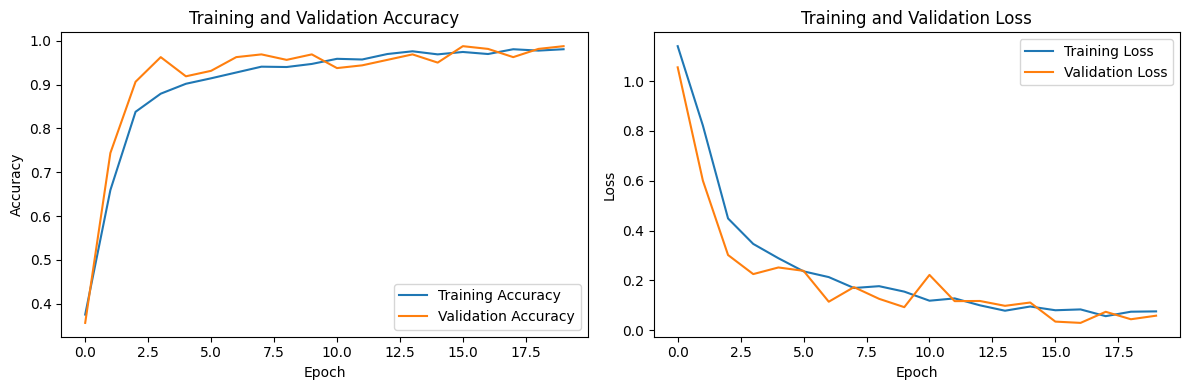

In [17]:
# Menampilkan plot training dan validasi accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Menampilkan plot training dan validasi loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Loss dan akurasi data training

In [18]:
score = model.evaluate(train_generator, batch_size=32)
print('loss     : {}'.format(score[0]))
print('accuracy : {}'.format(score[1]))

42/42 [==============================] - 11s 265ms/step - loss: 0.0232 - accuracy: 0.9954
loss     : 0.023247607052326202
accuracy : 0.9954338073730469


Loss dan akurasi data validation

In [19]:
score = model.evaluate(validation_generator, batch_size=32)
print('loss     : {}'.format(score[0]))
print('accuracy : {}'.format(score[1]))

28/28 [==============================] - 8s 286ms/step - loss: 0.0421 - accuracy: 0.9851
loss     : 0.04209161549806595
accuracy : 0.9851258397102356


Berdasarkan plot accuracy dan loss dari training model klasifikasi untuk memprediksi rock-paper-scissors, dapat disimpulkan bahwa model dapat memprediksi dengan akurasi yang tinggi. Diketahui, akurasi model mencapai 99% untuk data training dan 98% untuk data validation. Hal ini menunjukkan bahwa model telah mampu mempelajari pola dari data training dan dapat memprediksi dengan baik pada data yang belum pernah dilihat sebelumnya.

Loss model juga mengalami penurunan secara konsisten dari awal hingga akhir pelatihan. Hal ini menunjukkan bahwa model semakin baik dalam memprediksi kelas dari gambar rock paper scissors.

Penggunaan callback EarlyStopping dengan nilai patience=7 juga terbukti efektif dalam mencegah overfitting. Hal ini terlihat dari grafik accuracy yang mulai mendatar pada epoch ke-10, sementara loss masih terus menurun.

Secara keseluruhan, model klasifikasi rock paper scissors yang dilatih dapat dikatakan telah berhasil. Model tersebut dapat memprediksi dengan akurasi yang tinggi dan tidak mengalami overfitting.

# **Menguji Model untuk Melakukan Prediksi Gambar Input**

Menguji dengan gambar Rock

Saving 1000_F_243068956_Gk65xafr8n50DcuEFvdf0GPCrbN28ICE (1).jpg to 1000_F_243068956_Gk65xafr8n50DcuEFvdf0GPCrbN28ICE (1).jpg
1/1 [==============================] - 0s 20ms/step


Image Category Prediction Result : Rock



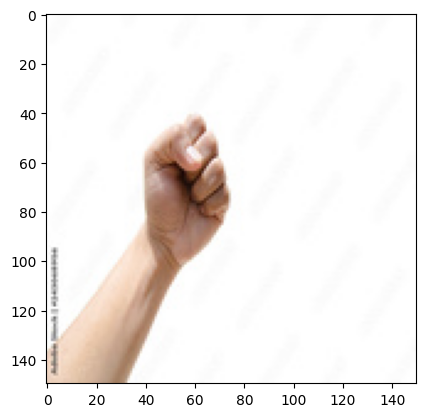

In [27]:
from tensorflow.keras.preprocessing import image

# Upload gambar untuk diprediksi
uploaded = files.upload()

for upload in uploaded.keys():
  # Prediksi gambar
  path = upload
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print('\n')
  if classes[0][1] == 1:
    print('Image Category Prediction Result : Rock\n')
  elif classes[0][0] == 1:
    print('Image Category Prediction Result : Paper\n')
  else:
    print('Image Category Prediction Result : Scissors\n')

Menguji dengan gambar Paper

Saving close-up-of-childs-hand-playing-rock-paper-scissors-BRY8WF (1).jpg to close-up-of-childs-hand-playing-rock-paper-scissors-BRY8WF (1).jpg
1/1 [==============================] - 0s 20ms/step


Image Category Prediction Result : Paper



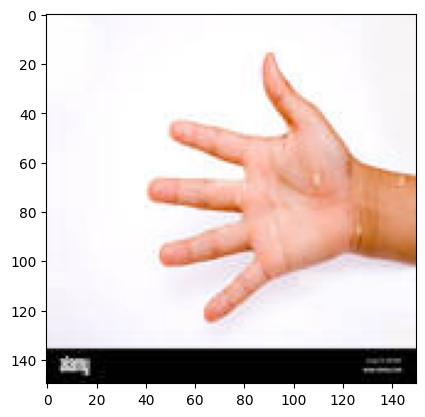

In [21]:
from tensorflow.keras.preprocessing import image

# Upload gambar untuk diprediksi
uploaded = files.upload()

for upload in uploaded.keys():
  # Prediksi gambar
  path = upload
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print('\n')
  if classes[0][1] == 1:
    print('Image Category Prediction Result : Rock\n')
  elif classes[0][0] == 1:
    print('Image Category Prediction Result : Paper\n')
  else:
    print('Image Category Prediction Result : Scissors\n')

Menguji dengan gambar Scissors

Saving Rock-paper-scissors__scissors___1_-removebg-preview (3).png to Rock-paper-scissors__scissors___1_-removebg-preview (3).png
1/1 [==============================] - 0s 20ms/step


Image Category Prediction Result : Scissors



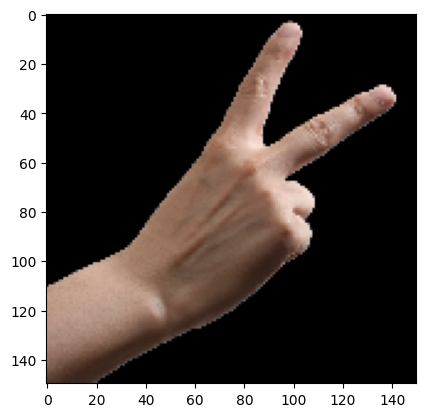

In [37]:
from tensorflow.keras.preprocessing import image

# Upload gambar untuk diprediksi
uploaded = files.upload()

for upload in uploaded.keys():
  # Prediksi gambar
  path = upload
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print('\n')
  if classes[0][1] == 1:
    print('Image Category Prediction Result : Rock\n')
  elif classes[0][0] == 1:
    print('Image Category Prediction Result : Paper\n')
  else:
    print('Image Category Prediction Result : Scissors\n')